## note on 2020.1.20
1. pick out which date have failure casese
2. animiate the prediction and ground truth to see the reason

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

from rainymotion import models, metrics, utils
from collections import OrderedDict
import h5py
import wradlib.ipol as ipol
from datetime import datetime,timedelta

import joblib
import pandas as pd
data_folder = "/Users/jiang/data/jma_radar"
#daily_folder = "/Users/jiang/data/jma_radar/2019_daily_unit8"
daily_folder = "/Users/jiang/data/jma_radar"

/Users/jiang/github_all/rainymotion/docs/notebooks


In [110]:
csv_path = os.path.join(data_folder,"threat_coverage.csv")
data = pd.read_csv(csv_path)

### failure is due to missing radar data

In [111]:
data[data['threat'] == 0]['yday'].value_counts()

166    6
Name: yday, dtype: int64

In [114]:
data[data['yday']==166]

,datetime,threat,coverage,yday
9127,2019-06-15 00:00:00,0.000000,38.406250,166
9128,2019-06-15 00:05:00,0.000000,38.156250,166
9129,2019-06-15 00:10:00,0.000000,37.968750,166
9130,2019-06-15 00:15:00,0.516785,37.437500,166
9131,2019-06-15 00:20:00,0.519472,36.875000,166
...,...,...,...,...
9406,2019-06-15 23:35:00,0.433767,12.031250,166
9407,2019-06-15 23:40:00,0.453369,12.140625,166
9408,2019-06-15 23:45:00,0.454970,12.195312,166
9409,2019-06-15 23:50:00,0.462757,12.304688,166


## check a specific datetime
- only threat score

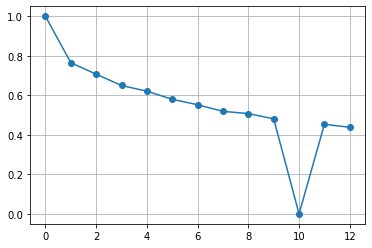

In [115]:
time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h
dt = datetime(2019, 6, 15, 12, 0)
dt_now = dt + timedelta(seconds = time_step)
dt_12  = dt + timedelta(seconds = time_step * 13)
yday_str = dt.strftime('%Y_%m_%d')
yday_now = dt_now.strftime('%Y_%m_%d')
yday_12  = dt_12.strftime('%Y_%m_%d')

daily_database = {}
inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)
if yday_str not in daily_database:
    daily_database[yday_str] = joblib.load(os.path.join(daily_folder, 
                                                        f"jma_radar_uint8_{yday_str}.joblib")) 
if yday_12 not in daily_database:
    daily_database[yday_12]  = joblib.load(os.path.join(daily_folder,
                                                        f"jma_radar_uint8_{yday_12}.joblib")) 

sequence_in_day = int(dt.hour*12 + (dt.minute)/5)    
inputs[0,:,:] = daily_database[yday_str][sequence_in_day]/10.0
inputs[1,:,:] = daily_database[yday_now][(sequence_in_day + 1)%288]/10.0
    
model = models.Dense()    
model.input_data = inputs
model.lead_steps = 13
nowcast = model.run()  # shape (13, 1000, 1000)
dense_13_th = []  # threat score
for i in range (13):
    dt_predit = dt_now + timedelta(seconds = time_step * i)
    yday_pre = dt_predit.strftime('%Y_%m_%d')
    sequence = int(dt_predit.hour*12 + (dt_predit.minute)/5)   
    ground_truth =  daily_database[yday_pre][sequence]/10.0
    dense_13_th.append(metrics.CSI(ground_truth,nowcast[i], threshold = threshold))
plt.plot(dense_13_th,'o-')
plt.grid()
plt.show()

## make time sequence images and add score

In [5]:
time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h
dt = datetime(2020, 1, 23 , 0, 0)
dt_now = dt + timedelta(seconds = time_step)
dt_12  = dt + timedelta(seconds = time_step * 13)
yday_str = dt.strftime('%Y_%m_%d')
yday_now = dt_now.strftime('%Y_%m_%d')
yday_12  = dt_12.strftime('%Y_%m_%d')
hh = str(dt_now.hour).zfill(2) 
mm = str(dt_now.minute).zfill(2)

daily_database = {}
inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)
if yday_str not in daily_database:
    daily_database[yday_str] = joblib.load(os.path.join(daily_folder, 
                                                        f"jma_radar_uint8_{yday_str}.joblib")) 
if yday_12 not in daily_database:
    daily_database[yday_12]  = joblib.load(os.path.join(daily_folder,
                                                        f"jma_radar_uint8_{yday_12}.joblib")) 

sequence_in_day = int(dt.hour*12 + (dt.minute)/5)    
inputs[0,:,:] = daily_database[yday_str][sequence_in_day]/10.0
inputs[1,:,:] = daily_database[yday_now][(sequence_in_day+1)%288]/10.0
    
model = models.Dense()    
model.input_data = inputs
model.lead_steps = 13
nowcast = model.run()  # shape (13, 1000, 1000)
dense_13_th = []  # threat score
for i in range (13):
    dt_predit = dt_now + timedelta(seconds = time_step * i)
    yday_pre = dt_predit.strftime('%Y_%m_%d')
    sequence = int(dt_predit.hour*12 + (dt_predit.minute)/5)   
    ground_truth =  daily_database[yday_pre][sequence]/10.0
    hits, misses, falsealarms, _ = metrics.prep_clf(ground_truth,nowcast[i], threshold = threshold)
    #dense_13_th.append(metrics.CSI(ground_truth,nowcast[i], threshold = threshold))
    threat =  hits / (hits + misses + falsealarms)
    recall =  hits / (hits + misses)
    precision = hits / (hits + falsealarms)
    
    plt.figure(dpi = 100)
    
    image1 = ground_truth
    image2 = nowcast[i]
    plt.imshow(np.log(image1 + 0.01),cmap = 'Reds',origin = "lower")
    plt.imshow(np.log(image2 + 0.01).astype('float32'),cmap = 'Blues',origin = "lower",alpha = 0.5)
    plt.title(f"now = {yday_now}-{hh}:{mm} UTC,+{str(i*5).zfill(2)}min")
    plt.text(20, 950, f"rainy pixels = {np.sum(image1 >= threshold)/(1e6 - 132396) *100 :.1f} %")
    plt.text(20, 900, f"threshold = {threshold} mm/h")
    plt.text(20, 850, f"threat = {threat:.2f}")
    plt.text(20, 800, f"recall = {recall:.2f}")
    plt.text(20, 750, f"precision = {precision:.2f}")
    plt.text(20, 700, "Truth(Reds)",color = "red")
    plt.text(20, 650, "Forecast(Blues)",color = "blue")
    plt.grid()
    plt.tight_layout(h_pad=0.5)
    plt.savefig("JMA_rainymotion_image_score" + str(i).zfill(2) + ".png",format = "png",bbox_inches='tight')
    plt.close()

## make gif animiation and delete png images

In [6]:
import imageio
png_files = glob.glob("./JMA_rainymotion_image_score*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
    os.system(f"rm -r {filename}")
output_file = f'JMA_rainymotion_image_score-{yday_now}.gif'
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

13
